### Преамбула

In [142]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot
import matplotlib.patches
%matplotlib inline
import seaborn

In [143]:
def pointsSet(initialData, xBorders, yBorders, size=7, title = ""):
    measurement = np.array((abs(xBorders[0] - xBorders[1]), abs(yBorders[0] - yBorders[1])))
    measurement = measurement*(size/np.max(measurement))
    points, ax = matplotlib.pyplot.subplots(figsize = measurement)
    ax.set_title(title)
    ax.set_xlim(*xBorders)
    ax.set_ylim(*yBorders)
    ax.axis("equal")
    ax.scatter(initialData[0],initialData[1],c="Gray")
    return points

In [144]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

def maxDistance(initialData):
    max_val = 0
    index = [0,0]
    for in1, p1 in enumerate(initialData.T):
        for in2, p2 in enumerate(initialData.T):
            if distance(p1, p2)> max_val:
                max_val = distance(p1, p2)
                index = [in1, in2]
    return sorted(index, key = lambda ind: initialData[0,ind])

def distantPoints(initialData, xBorders, yBorders, maxIndex, size =7, title = ""):
    points= pointsSet(initialData, xBorders, yBorders, size , title)
    ax = points.axes[0]
    ax.plot([initialData[0,maxIndex[0]], initialData[0,maxIndex[1]]], [initialData[1,maxIndex[0]], initialData[1,maxIndex[1]]], c="Green")
    return points

In [145]:
def rotatePoint (point, center, angle):
    ox = (point[0] - center[0])*np.cos(angle) - (point[1]- center[1])*np.sin(angle) + center[0]
    oy = (point[0] - center[0])*np.sin(angle) + (point[1]- center[1])*np.cos(angle) + center[1]
    return np.vstack((ox,oy))

def findAngle(initialData, maxIndex):
    return np.arctan((initialData[1,maxIndex[1]] -initialData[1,maxIndex[0]])/(initialData[0,maxIndex[1]] -initialData[0,maxIndex[0]]))

In [146]:
def changePoints(rinitialData, xBorders, yBorders, maxIndex, size =7, title = ""):
    points= pointsSet(rinitialData, xBorders, yBorders, size , title)
    ax = points.axes[0]
    ax.plot([rinitialData[0,maxIndex[0]], rinitialData[0,maxIndex[1]]], [rinitialData[1,maxIndex[0]], rinitialData[1,maxIndex[1]]],c="Green")
    return points

In [147]:
def highS(rinitialData):
    return [np.argmin(rinitialData,axis=1)[1], np.argmax(rinitialData,axis=1)[1]]

def vNorm(rinitialData, maxIndex, vData):
    seg1 = np.array([rinitialData.T[vData[0]], [rinitialData.T[vData[0],0], rinitialData.T[maxIndex[0],1]]]).T
    seg2 = np.array([rinitialData.T[vData[1]], [rinitialData.T[vData[1],0], rinitialData.T[maxIndex[0],1]]]).T
    return seg1, seg2

def points_with_perpendiculars(rinitialData, maxIndex,vData, segments, size = 7, title= ""):
    new_yBorders = rinitialData[1,vData[0]]*1.1, rinitialData[1,vData[1]]*1.1
    new_xBorders = rinitialData[0,maxIndex[0]]*1.1, rinitialData[0,maxIndex[1]]*1.1
    fig = distantPoints(rinitialData, new_xBorders, new_yBorders,maxIndex, size, title )
    ax = fig.axes[0]
    ax.plot(segments[0][0], segments[0][1], c="Maroon")
    ax.plot(segments[1][0], segments[1][1], c="Maroon")
    return fig

In [148]:
def compression_ratio(rinitialData, maxIndex, vData):
    x_length = np.abs(rinitialData[0,maxIndex[1]] - rinitialData[0,maxIndex[0]])
    y_length = np.abs(rinitialData[1,vData[1]] - rinitialData[1,vData[0]])
    return y_length/ x_length

def make_square_initialData(rinitialData, maxIndex, segments, coef):
    s_rinitialData = rinitialData.copy()
    s_rinitialData[0]= s_rinitialData[0,maxIndex[0]] + (s_rinitialData[0] - s_rinitialData[0,maxIndex[0]])* coef
    s_segments= segments.copy()
    for i in range(len(s_segments)):
        s_segments[i][0]= s_rinitialData[0,maxIndex[0]] + (s_segments[i][0] - s_rinitialData[0,maxIndex[0]])* coef
    return s_rinitialData, s_segments

In [149]:
def find_center(initialData,maxIndex, vData):
    return np.array([(initialData[0,maxIndex[0]]+initialData[0,maxIndex[1]])/2, (initialData[1,vData[0]]+initialData[1,vData[1]])/2 ])

In [150]:
class CirclePl:
    def __init__(self, xy, radius, initialData):
        self.xy = xy
        self.radius = radius
        self.count = self._count_of_inside_dots(initialData)
    def _count_of_inside_dots(self,initialData):
        #a circle class that stores the number of points that are inside (including the border) 
        count =0
        for dot in initialData.T:
            if distance(dot, self.xy) <= self.radius:
                count+=1
        return count
    
    def __str__(self):
        return f"CIRCLE - COORDINATES: {self.xy}, RADIUS: {self.radius:.{2}f}, COUNT: {self.count:.{2}f}"

In [151]:
def CirclesP(s_rinitialData, maxIndex,vData, segments, centr, circlesList,size = 7, title= ""):
    fig = points_with_perpendiculars(s_rinitialData, maxIndex, vData, segments, size = size, title = title)
    ax = fig.axes[0]
    ax.scatter(centr[0], centr[1], color ="Red")
    for circle in circlesList:
        ax.add_patch(matplotlib.patches.Circle(circle.xy,circle.radius, fill= False, color ="Lime"))
    return fig

In [152]:
class EllipsePl:
    def __init__(self, xy, width, height, N, angle=0, count=0):
        self.xy = xy
        self._width = width 
        self._height = height
        self.angle = angle
        self.count = count
        self.area = self._area_calculation()
        self.prob = self.count / (N+1)# probability - that points are inside the ellipse

    def _area_calculation(self):
        return np.pi *self._width*self._height/4

    # Decorator for width and height
    # While changing width and height the are will be changed

    @property
    def width(self):
        return self._width
    @width.setter
    def width(self, value):
        if value <= 0:
            raise ValueError('Cannot be <=0')
        self._width = value
        self.area= self._area_calculation()
    
    @property
    def height(self):
        return self._height
    
    @height.setter
    def height(self, value):
        if value <= 0:
            raise ValueError('Cannot be <=0')
        self._height = value
        self.area= self._area_calculation()



    def __str__(self):
        return f"ELLIPSE - COORDINATES: {self.xy}, WIDTH: {self._width:.{2}f}, HEIGHT: {self._height:.{2}f}, ANGLE: {self.angle:.{2}f}, COUNT: {self.count}, AREA: {self.area:.{2}f}, PROB: {self.prob:.{2}f}"
    def __repr__(self):
        return f"#ELLIPSE c:({self.xy[0]},{self.xy[0]}), (w/h/a:{self._width},{self._height},{self.angle}), count: {self.count}, area: {self.area}, prob: {self.prob} #"
    

In [153]:
def changePoints_with_ellipses(rinitialData, maxIndex, vData, segments, center, ellipsesList, size =7, title =""):
    fig = points_with_perpendiculars(rinitialData, maxIndex, vData, segments, size = size, title = title)
    ax = fig.axes[0]
    ax.scatter(center[0], center[1], color ="Red")
    for ell in ellipsesList:
        ax.add_patch(matplotlib.patches.Ellipse(ell.xy, ell.width, ell.height, angle = ell.angle, fill= False, color ="Lime"))
    return fig

### Генеруємо точки

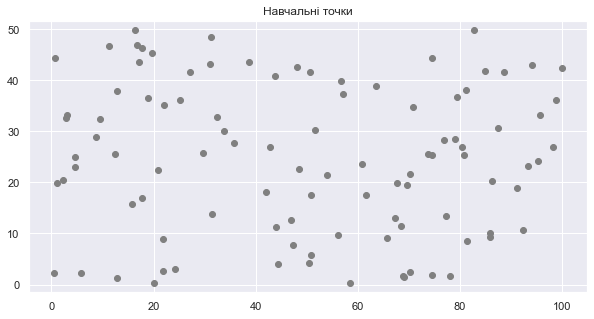

In [154]:
xBorders = [0,100]
yBorders = [0,50]
N = 100

seaborn.set_theme()
np.random.seed(22)

initialData = np.vstack((np.random.uniform(xBorders[0],xBorders[1], N), np.random.uniform(yBorders[0],yBorders[1], N)))
sop = pointsSet(initialData, xBorders, yBorders,size = 10, title= "Навчальні точки")

### Шукаємо найбільш віддалені точки

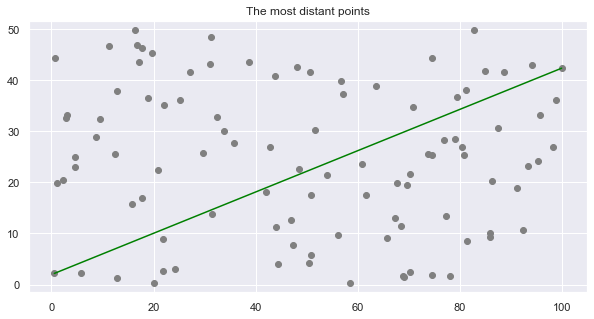

In [155]:
maxIndex = maxDistance(initialData)
dp = distantPoints(initialData, xBorders, yBorders, maxIndex, size = 10, title= "The most distant points")

### Виконуємо поворот

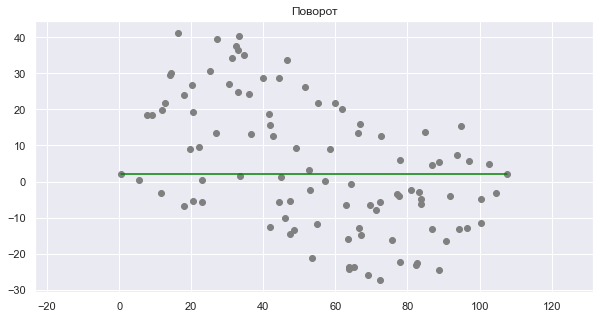

In [156]:
angle = findAngle(initialData, maxIndex)
rinitialData = rotatePoint(initialData, initialData[:,maxIndex[0]], -1*angle)
tp = changePoints(rinitialData, xBorders, yBorders, maxIndex, size=10, title = "Поворот")

### Знаходимо висоту та ширину

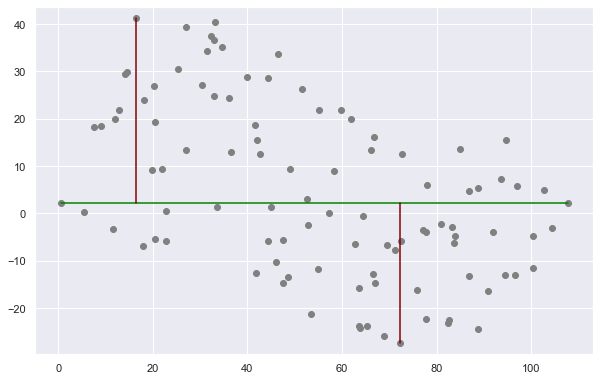

In [157]:
vData = highS(rinitialData)
segments = np.array(vNorm(rinitialData, maxIndex, vData))
PWP= points_with_perpendiculars(rinitialData,maxIndex,vData, segments, size = 10)

### Cтискаємо у квадрат

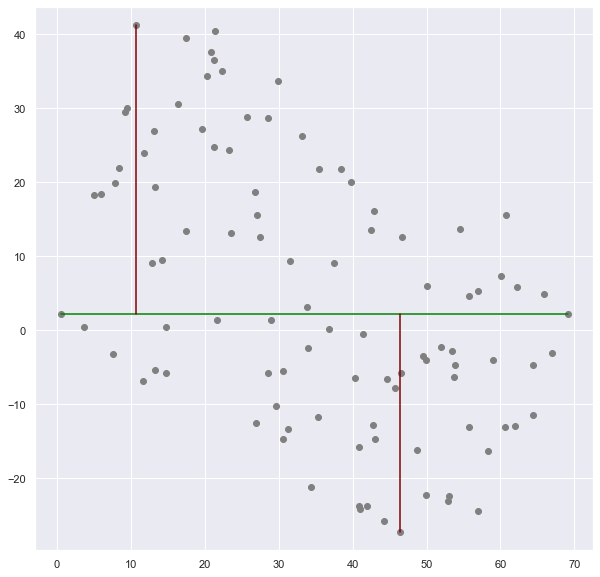

In [158]:
coef = compression_ratio(rinitialData, maxIndex, vData)
s_rinitialData, s_segments = make_square_initialData(rinitialData, maxIndex, segments, coef)
CPWP = points_with_perpendiculars(s_rinitialData,maxIndex,vData, s_segments, size =10)

### Будуємо концентричні кола

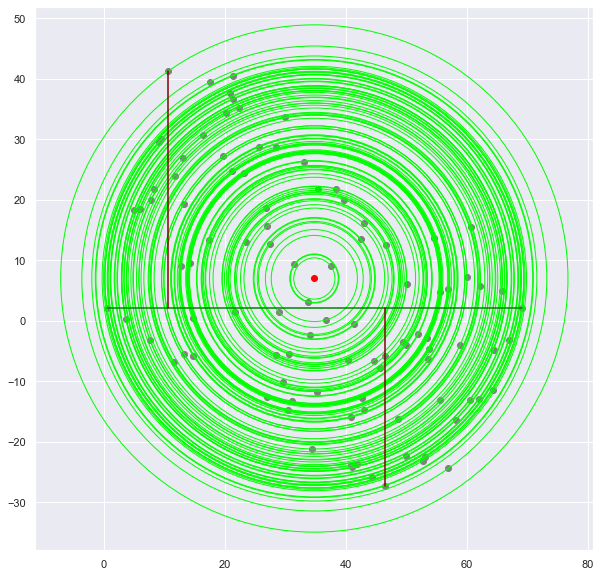

In [159]:
circlesList = []
new_center = find_center(s_rinitialData, maxIndex, vData)
for dot in s_rinitialData.T:
    circlesList.append(CirclePl(new_center, distance(dot, new_center), s_rinitialData))
pwc = CirclesP(s_rinitialData,maxIndex,vData, s_segments, new_center, circlesList, size = 10)

### Обернене перетворення

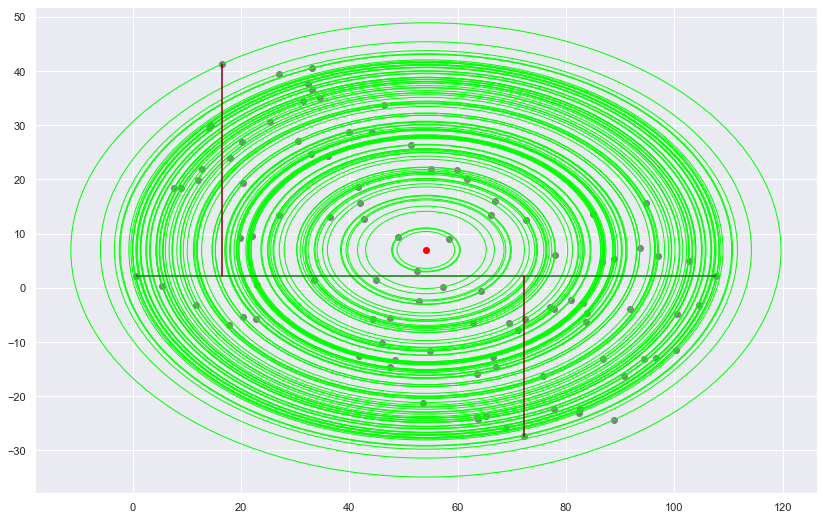

In [160]:
ellipsesList = []
inv_coef = 1/coef
r_center = s_rinitialData.T[maxIndex[0]] + (new_center - s_rinitialData.T[maxIndex[0]])*np.array([inv_coef,1])
for circle in circlesList:
    ellipsesList.append(EllipsePl(r_center, 2*circle.radius*inv_coef, 2*circle.radius, N, angle=0, count=circle.count))
tpwe = changePoints_with_ellipses(rinitialData, maxIndex, vData, segments, r_center, ellipsesList, size = 14)

### Повертаємо назад

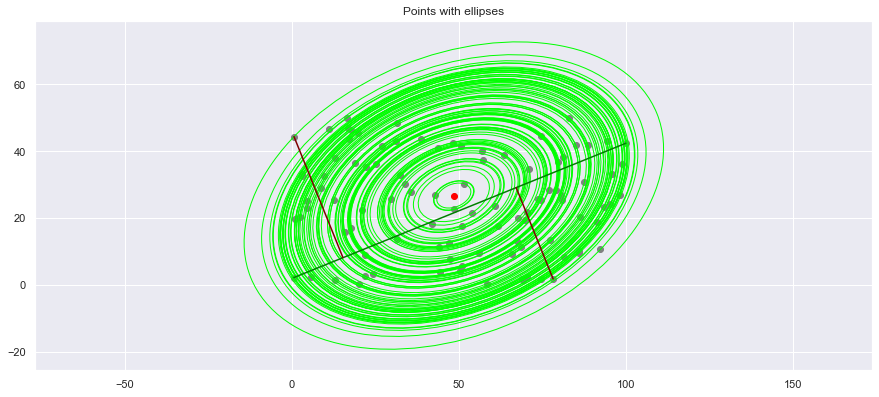

In [161]:
center = rotatePoint(r_center,initialData[:,maxIndex[0]], angle)
for ell in ellipsesList:
    ell.angle = np.degrees(angle)
    ell.xy = center
segments_r = []
for seg in segments:
    segments_r.append(rotatePoint(seg,initialData[:,maxIndex[0]], angle))
pwe = changePoints_with_ellipses(initialData, maxIndex, vData, segments_r, center, ellipsesList, size = 15,
          title = "Points with ellipses")

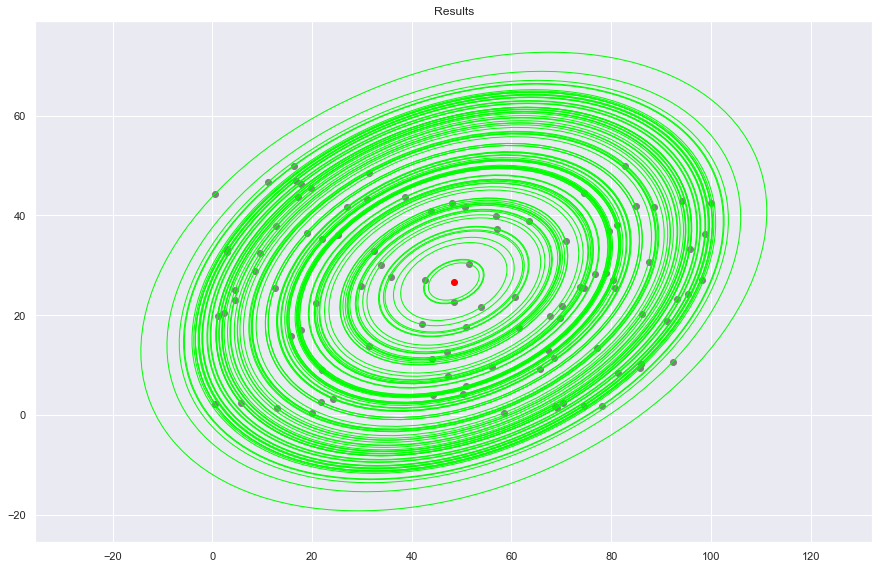

In [162]:
def ellRes(initialData, ellipsesList, center, size =7 ,title = ""):
    new_yBorders = rinitialData[1,vData[0]]*1.1, rinitialData[1,vData[1]]*1.1
    new_xBorders = rinitialData[0,maxIndex[0]]*1.1, rinitialData[0,maxIndex[1]]*1.1
    fig= pointsSet(initialData, new_xBorders, new_yBorders, size , title)
    ax = fig.axes[0]
    ax.scatter(center[0], center[1], color = "Red")
    for ell in ellipsesList:
        ax.add_patch(matplotlib.patches.Ellipse(ell.xy, ell.width, ell.height, angle = ell.angle, fill= False, color ="Lime"))
    return fig

paef = ellRes(initialData, ellipsesList, center, size =15 ,title = "Results")

In [167]:
ans = pd.DataFrame()
radius_list = []
count_list = []
area_list = []
prob_list = []
for i in range(len(circlesList)):
    radius_list.append(str(round(circlesList[i].radius, 2)))
    count_list.append(str(round(ellipsesList[i].count, 2)))
    area_list.append(str(round(ellipsesList[i].area, 2)))
    prob_list.append(str(round(ellipsesList[i].prob, 2)))
ans["Радіус кола"] = radius_list
ans["Кількість точок"] = count_list
ans["Площа еліпса"] = area_list
ans["Ймовірність"] = prob_list
ans

,Радіус кола,Кількість точок,Площа еліпса,Ймовірність
0,18.53,28,1686.36,0.28
1,15.22,21,1138.38,0.21
2,8.09,5,321.11,0.05
3,34.64,93,5892.24,0.92
4,31.01,72,4723.94,0.71
...,...,...,...,...
95,27.01,59,3583.49,0.58
96,22.32,45,2447.43,0.45
97,23.08,48,2615.71,0.48
98,31.83,78,4976.95,0.77
